In [1]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import tensorflow as tf
import random as rn 


In [2]:
seed_num =42
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [51]:
n_hours = 3
n_features = 43
train_num_24 = 2789
train_num_25 = 2891
train_num_19 = 1934

In [52]:
from os.path import join
df = pd.read_excel('rain_data.xlsx')
df.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,데이터 집단 6,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


# df_matrix 

## 에서는 일단 앞에 date 관련 된 정보를 다 삭제 한 상황이다. 

In [53]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()
df_matrix = df_matrix[0:train_num_25, 5:]
print(df_matrix)

df_matrix = df_matrix.astype('float32')

# scaler = MinMaxScaler(feature_range=(0, 1))
# df_matrix = scaler.fit_transform(df_matrix)

df_matrix

[[189.1         6.4         7.        ...   8.          2.54
  122.61     ]
 [216.9519618   6.3         7.        ...  10.          2.53
  122.6      ]
 [251.4244187   6.4         7.        ...  11.          2.53
  122.59     ]
 ...
 [491.9548045   4.1089      1.        ...   1.          2.98
  137.155    ]
 [481.1030831   3.3854      1.        ...   1.          2.96
  137.165    ]
 [470.4581089   3.2841      1.        ...   1.          2.94
  137.18     ]]


array([[189.1    ,   6.4    ,   7.     , ...,   8.     ,   2.54   ,
        122.61   ],
       [216.95197,   6.3    ,   7.     , ...,  10.     ,   2.53   ,
        122.6    ],
       [251.42442,   6.4    ,   7.     , ...,  11.     ,   2.53   ,
        122.59   ],
       ...,
       [491.9548 ,   4.1089 ,   1.     , ...,   1.     ,   2.98   ,
        137.155  ],
       [481.1031 ,   3.3854 ,   1.     , ...,   1.     ,   2.96   ,
        137.165  ],
       [470.4581 ,   3.2841 ,   1.     , ...,   1.     ,   2.94   ,
        137.18   ]], dtype=float32)

In [60]:
# print(df_matrix)
lag = series_to_supervised(df_matrix, n_hours,1)

lag = lag.values

tmp = lag.shape[1]-42


lag = lag[:,0:tmp]
print("lag")
print(lag)
print("lag_shape")
print(lag.shape)

lag
[[189.1       6.4       7.      ...   2.53    122.59    302.8122 ]
 [216.95197   6.3       7.      ...   2.53    122.585   384.78342]
 [251.42442   6.4       7.      ...   2.53    122.575   512.5012 ]
 ...
 [522.98944  36.5129   10.      ...   3.      137.145   491.9548 ]
 [513.3684   22.7836    6.      ...   2.98    137.155   481.1031 ]
 [502.84683   8.2586    2.      ...   2.96    137.165   470.4581 ]]
lag_shape
(2888, 130)


In [61]:
n_train_hours = train_num_19
train = lag[:n_train_hours, :]
test = lag[n_train_hours:, :]

# train_X, train_y

train_X 에는 series 함수가 적용이 되어있는 상태 이다 . 

train_y 에는 trian_X 에서 앞부분말고 제일 뒤에 있는 부분들만 띄워져 있는 상태 이다. 

# test_X , Test_y

testx, testy 가 너무 헷갈리게 되어있다. 원래는 validation 인말이다.. 

그런데, train_X 를 reshape 하는데 에러가 나고 있다. 왜인지는 모르겠다. 

In [75]:
n_obs = n_hours * (n_features)


# train_X, train_y = train[:, :n_obs], train[:, -1]
train_X, train_y = train[:, :n_obs], train[:, -130]
print("train_X, trian_X.shape")
print(train_X.shape)
print(train_X)
print('\ntrain_y:')
print(train_y.shape)
print(train_y)
test_X, test_y = test[:, :n_obs], test[:, -(n_features)]
print("\ntest_X")
print(test_X.shape)
print(test_X)
print("\ntest_y")
print(test_y.shape)
# print(test_y)

#print('test_y: ',test_y)12
print("train_X.shape, len(train_X), train_y.shape")
print(train_X.shape, len(train_X), train_y.shape)



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, (n_features)))
test_X = test_X.reshape((test_X.shape[0], n_hours, (n_features)))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X, trian_X.shape
(1934, 130)
[[189.1        6.4        7.       ...   2.53     122.59     302.8122  ]
 [216.95197    6.3        7.       ...   2.53     122.585    384.78342 ]
 [251.42442    6.4        7.       ...   2.53     122.575    512.5012  ]
 ...
 [929.60425   86.4227    79.       ...   1.97     130.13      65.966835]
 [917.2957    86.3195    79.       ...   1.96     130.1       69.46721 ]
 [ 63.579285  60.7854    50.       ...   1.95     130.07      74.20873 ]]

train_y:
(1934,)
[189.1      216.95197  251.42442  ... 929.60425  917.2957    63.579285]

test_X
(954, 130)
[[ 65.966835  60.7854    50.       ...   1.94     130.035     80.27736 ]
 [ 69.46721   59.8524    50.       ...   1.94     130.005     87.74844 ]
 [ 74.20873   58.5964    36.       ...   1.93     129.975     96.68539 ]
 ...
 [522.98944   36.5129    10.       ...   3.       137.145    491.9548  ]
 [513.3684    22.7836     6.       ...   2.98     137.155    481.1031  ]
 [502.84683    8.2586     2.       ...   2

ValueError: cannot reshape array of size 251420 into shape (1934,3,44)

In [58]:
##1
n_features = 43
n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print("\ntrain_X.shape, len(train_X), train_y.shape")
print(train_X.shape, len(train_X), train_y.shape)
print("\ntrain_X")
print(train_X)
print("\ntrain_y")
print(train_y)
print("\ntest_X")
print(test_X)
print("\ntest_y")
print(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("\n\ntrain_X.shape, train_y.shape, test_X.shape, test_y.shape")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print("\ntrain_X")
print(train_X)
print("\ntrain_y")
print(train_y)
#===========================================================================================
print("=================================================")
n_features = 44
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print("\ntrain_X.shape, len(train_X), train_y.shape")
print(train_X.shape, len(train_X), train_y.shape)
print("\ntrain_X")
print(train_X)
print("\ntrain_y")
print(train_y)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("\n\ntrain_X.shape, train_y.shape, test_X.shape, test_y.shape")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print("\ntrain_X")
print(train_X)
print("\ntrain_y")
print(train_y)


train_X.shape, len(train_X), train_y.shape
(1934, 129) 1934 (1934,)

train_X
[[189.1        6.4        7.       ...  11.         2.53     122.59    ]
 [216.95197    6.3        7.       ...  14.         2.53     122.585   ]
 [251.42442    6.4        7.       ...  16.         2.53     122.575   ]
 ...
 [929.60425   86.4227    79.       ...   7.         1.97     130.13    ]
 [917.2957    86.3195    79.       ...   7.         1.96     130.1     ]
 [ 63.579285  60.7854    50.       ...   6.         1.95     130.07    ]]

train_y
[122.59  122.585 122.575 ... 130.13  130.1   130.07 ]

test_X
[[ 65.966835  60.7854    50.       ...   3.         1.94     130.035   ]
 [ 69.46721   59.8524    50.       ...   0.         1.94     130.005   ]
 [ 74.20873   58.5964    36.       ...   0.         1.93     129.975   ]
 ...
 [522.98944   36.5129    10.       ...   1.         3.       137.145   ]
 [513.3684    22.7836     6.       ...   1.         2.98     137.155   ]
 [502.84683    8.2586     2.       ..

ValueError: cannot reshape array of size 249486 into shape (1934,3,44)

In [10]:
# #testing
# model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))

# model.add(Dense(1))

In [11]:
# testing
model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))
model.add(LSTM(20, input_shape = (train_X.shape[1],train_X.shape[2]), activation = 'tanh', return_sequences = False))
model.add(Dense(1))

2021-09-08 19:30:52.649992: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-09-08 19:30:52.673778: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcc9aaaa0d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-08 19:30:52.673793: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [12]:
# # optimizer =tf.train.AdamOptimizer(lea)

# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
adam = tf.keras.optimizers.Adam(lr =0.0001)
model.compile(loss='mse', optimizer='adam')

# history = model.fit(train_X, train_y, 
#                                     epochs=100, 
#                                     batch_size=16,
#                                     validation_data=(test_X, test_y), 
#                                     callbacks=[early_stop, checkpoint])
history = model.fit(train_X, train_y, 
                                    epochs=100, 
                                    batch_size=32,
                                    validation_data=(test_X, test_y))

pred = model.predict(test_X)

Epoch 1/100
61/61 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0011
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 7.4757e-04
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.3957e-04
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: 7.8546e-04 - val_loss: 4.6788e-04
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: 5.8726e-04 - val_loss: 3.9546e-04
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: 4.7299e-04 - val_loss: 3.7971e-04
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: 4.0011e-04 - val_loss: 3.6331e-04
Epoch 8/100
61/61 [==============================] - 0s 3ms/step - loss: 3.3477e-04 - val_loss: 3.0952e-04
Epoch 9/100
61/61 [==============================] - 0s 3ms/step - loss: 2.7343e-04 - val_loss: 2.9860e-04
Epoch 10/100
61/61 [==============================] -

61/61 [==============================] - 0s 2ms/step - loss: 2.6060e-05 - val_loss: 2.5877e-05
Epoch 78/100
61/61 [==============================] - 0s 3ms/step - loss: 1.9841e-05 - val_loss: 2.3129e-05
Epoch 79/100
61/61 [==============================] - 0s 3ms/step - loss: 2.0714e-05 - val_loss: 2.8301e-05
Epoch 80/100
61/61 [==============================] - 0s 3ms/step - loss: 2.1847e-05 - val_loss: 1.8026e-05
Epoch 81/100
61/61 [==============================] - 0s 2ms/step - loss: 1.6419e-05 - val_loss: 3.4604e-05
Epoch 82/100
61/61 [==============================] - 0s 3ms/step - loss: 2.0005e-05 - val_loss: 2.3984e-05
Epoch 83/100
61/61 [==============================] - 0s 2ms/step - loss: 1.7961e-05 - val_loss: 2.0938e-05
Epoch 84/100
61/61 [==============================] - 0s 3ms/step - loss: 2.7790e-05 - val_loss: 2.6150e-05
Epoch 85/100
61/61 [==============================] - 0s 3ms/step - loss: 3.3353e-05 - val_loss: 2.5244e-05
Epoch 86/100
61/61 [=====================

In [13]:
RMSE = mean_squared_error(test_y,pred)**0.5
print(RMSE)
#0.0010039970273863338

0.003911033138274245


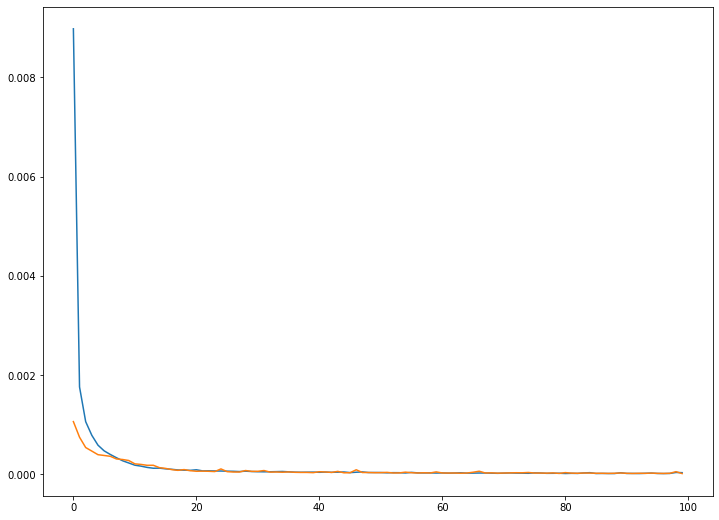

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

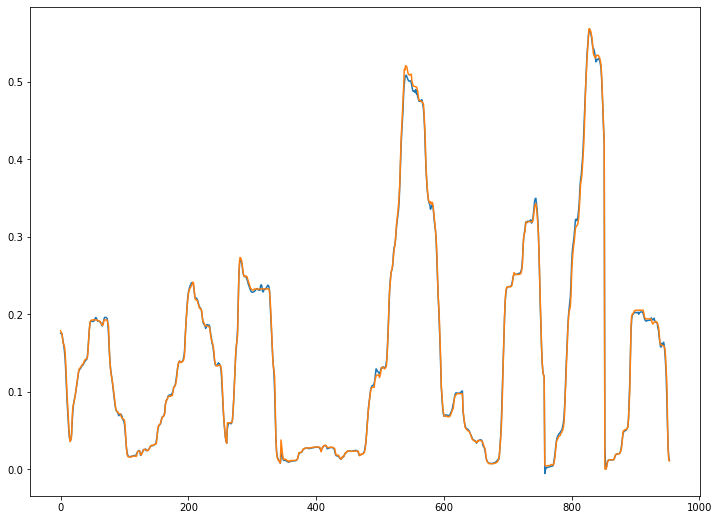

In [16]:
plt.figure(figsize=(12, 9))
plt.plot(pred,label='prediction')
plt.plot(test_y,label='real')
plt.show()